In [ ]:
# Application
import imutils
from keras.models import load_model
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imutils import contours
import tensorflow as tf
import string
from keras.utils import np_utils

In [ ]:
model = load_model("letter_number_cnn.h5")

In [ ]:
# https://pyimagesearch.com/2020/08/24/ocr-handwriting-recognition-with-opencv-keras-and-tensorflow/
# https://stackoverflow.com/questions/56698714/how-to-segment-characters-and-words-from-images-into-contours
# https://www.kaggle.com/code/aman10kr/offline-handwritten-text-ocr/notebook
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)
def get_word(img):
    word_image_list = []
    letters = []
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,thresh1 = cv2.threshold(gray ,127,255,cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=20)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="top-to-bottom")[0]
    # loop over the contours
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi = gray[y:y + h, x:x + w]
        word_image_list.append(roi)
    plt.imshow(image)
    return word_image_list

1/1 [==============================] - 0s 17ms/step
['A', 'I', 'P', '10OCT2022', 'DATE', '9841S68887', 'PHONE', 'S', 'BEN', 'NAME', 'MALE', 'GENDER', '20', 'AGE', '15', 'HAEMOGLOBIN', '5', 'REDBLOODCELL', '6000', 'WHITEBLOODCELL', '160', 'HEIGHT', '60', 'WEIGHT', '15', 'CALCIUM', '160', 'HDL']


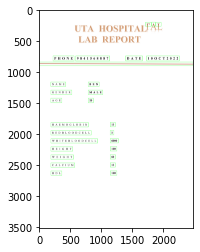

In [ ]:
def image_to_text(create_image, image_size=128):
  # Reshape image
  reshape_image = cv2.resize(create_image, (image_size, image_size), interpolation=cv2.INTER_AREA)
  # Normalizing the dataset
  reshape_image = tf.keras.utils.normalize(reshape_image, axis=1)
  # Put the color channel to the dimension
  reshape_image = np.array(reshape_image).reshape(-1, image_size, image_size, 1)
  prediction = model.predict(reshape_image)
  labels = list(range(0, 10)) + list(string.ascii_uppercase)
  return labels[np.argmax(prediction[0]) - 1]
# https://stackoverflow.com/questions/36255654/how-to-add-border-around-an-image-in-opencv-python
def enlarge_image(im, bordersize = 5):
  row, col = im.shape[:2]
  bottom = im[row-2:row, 0:col]
  mean = cv2.mean(bottom)[0]

  border = cv2.copyMakeBorder(
      im,
      top=bordersize,
      bottom=bordersize,
      left=bordersize,
      right=bordersize,
      borderType=cv2.BORDER_CONSTANT,
      value=[255, 255, 255]
  )

  return border
# # https://stackoverflow.com/questions/60515216/extracting-and-saving-characters-from-an-image
# Load image, grayscale, Otsu's threshold
# word save as pdf export to 300 resolution png
word_image_list = get_word("medical record.png")
context_list = []
for image in word_image_list:
  thresh = cv2.threshold(image, 0, 255, cv2.THRESH_OTSU + cv2.THRESH_BINARY_INV)[1]

  # Find contours, sort from left-to-right, then crop
  cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = cnts[0] if len(cnts) == 2 else cnts[1]
  cnts, _ = contours.sort_contours(cnts, method="left-to-right")

  # Filter using contour area and extract ROI
  ROI_number = 0
  text_list = []
  for c in cnts:
      area = cv2.contourArea(c)
      if area > 10:
          x,y,w,h = cv2.boundingRect(c)
          ROI = image[y:y+h, x:x+w]
          large_image = enlarge_image(ROI)
          text = image_to_text(large_image)
          text_list.append(text)
          cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
          ROI_number += 1
  context_list.append("".join([str(element) for element in text_list]))
print(context_list)

In [ ]:
def calculate_bmi(weight:int, height:int) -> float:
  return weight / (height * height)
def bmi_details(bmi:float) -> str:
  if bmi <= 18.5:
    bmi = float("{0:.2f}".format(bmi))
    bmi = str(bmi)
    text = 'Your bmi is '+bmi+' which means you are underweight. \n'
    text = text + 'You should contain more protien food in your diet like eggs milk fish green vegetables. \n\n'
      
  elif bmi > 18.5 and bmi < 25:
    bmi = float("{0:.2f}".format(bmi))
    bmi = str(bmi)
    text = 'Your bmi is '+bmi+' which means you are normal. \n\n'
    
  elif bmi > 25 and bmi < 30:
    bmi = float("{0:.2f}".format(bmi))
    bmi = str(bmi)
    text = 'Your bmi is '+bmi+ 'which means you are overweight. \n'
    text = text + 'You should avoid non-veg  do exercise regularly eat lots of green vegetables. \n\n'
    
  elif bmi > 30:
    bmi = float("{0:.2f}".format(bmi))
    bmi = str(bmi)
    text = 'Your bmi is '+bmi+'which means you are obese. \n\n'
  return text
def rbc_wbc(age:int, gender:str, hbc:int, rbc:int, wbc:int) -> str:
    text = ""
    if(age>0) and (age<=12):
        hb_count =hbc
        if(hb_count>=11.5 ) and (hb_count<=15.5):
            text = text + "HB is normal. \n\n"
        elif(hb_count<11.5):
            text = text + "HB is low. You must take Oranges, tomatoes, spinach , eggs , dry fruits. \n\n"
        else:
            text = text + " HB is high. \n\n"

        ########RBC  
        rbc_count = rbc
        if(rbc_count>=4.0 ) and (rbc_count<=5.5):
            text = text + "RBC is normal. \n\n"
        elif(rbc_count<4.0):
            text = text + "RBC is low. \n\n"
        else:
            text = text + "RBC is high. \n\n"

        #######WBC
        wbc_count = wbc
        if(wbc_count>=5000 ) and (wbc_count<=10000):
            text = text + "WBC is normal. \n\n"
        elif(wbc_count<5000):
            text = text + "WBC is low. \n\n"
        else:
            text = text + "WBC is high. \n\n"


    ############################################ MALE's HB WBC RBC ####################################   
    if(gender=="male"):
        hb_count = hbc
        if(hb_count>=13.5 ) and (hb_count<=17.5):
            text = text + "HB is normal. \n\n"
        elif(hb_count<13.5):
            text = text + "HB is low     You must take:                Oranges, tomatoes, spinach, eggs, dry fruits,banana , pomegranate ,beetroots. \n\n"
        else:
            text = text + "HB is high     You must take:               drink more water , Quit smoking if you smoke. and Take treatment of bloodletting. \n\n"

    ##########RBC
        rbc_count = rbc
        if(rbc_count>=4.7 ) and (rbc_count<=6.1):
            text = text + "RBC is normal   Just for good health take : egg yolk,peas,nuts,milk,cheese,cherries,grapefruit. \n\n"
        elif(rbc_count<4.7):
            text = text + "RBC is low      You must take :             spinach, soya, kiwi, fruits, carrot, sweet potatos. \n\n"
        else:
            text = text + "RBC is high     You have to avoid :         Smoking and drinking alcohol, drugs if any !, take treatment on radiation and blood draw. \n\n"

    ###########WBC   
        wbc_count = wbc
        if(wbc_count>=5000 ) and (wbc_count<=10000):
            text = text + "WBC is normal     Just for good health:      kiwi,critrus fruit ,spinach,papaya-leaves,yogurt,broccoli. \n\n"
        elif(wbc_count<5000):
            text = text + "WBC is low        You must take:            garlic,spinach,papaya-leaves,yogurt,broccoli,kiwi,critrus fruit. \n\n"
        else:
            text = text + "WBC is high       You must take:            garlic,grapes,herbs,soya,nuts,olive oil,black or green tea. \n\n"
            
    ######################################### FEMALE's HB WBC RBC ####################################
    else:
        hb_count = hbc
        if(hb_count>=12.0 ) and (hb_count<=15.5):    
            text = text + "HB is normal\n\n"

        elif(hb_count<12.0):
            text = text + "HB is low.        You must take:         \nOranges, tomatoes, spinach , eggs , dry fruits. \n\n"
        else:
            text = text + "HB is high.       You must :             drink more water , Quit smoking if you smoke. and Take treatment of bloodletting. \n\n"

    #########RBC
        rbc_count =rbc
        if(rbc_count>=4.2 ) and (rbc_count<=5.4):
            text = text + "RBC is normal.    Just for good health : egg yolk,peas,nuts,milk,cheese,cherries,grapefruit. \n\n"
        elif(rbc_count<4.2):
            text = text + "RBC is low.       You must take :        spinach, soya, kiwi, fruits, carrot, sweet potatos. \n\n"
        else:
            text = text + "RBC is high.      You have to avoid :    Smoking and drinking alcohol, drugs if any !, take treatment on radiation and blood draw. \n\n"

    #######WBC        
        wbc_count = wbc
        if(wbc_count>=4500 ) and (wbc_count<=11000):
            text = text + "WBC is normal.    Just for good health : kiwi,critrus fruit ,spinach,papaya-leaves,yogurt,broccoli. \n\n"
        elif(wbc_count<4500):
            text = text + "WBC is low.       You must take :        garlic,spinach,papaya-leaves,yogurt,broccoli,kiwi,critrus fruit. \n\n"
        else:
            text = text + "WBC is high.      You must take :        garlic,grapes,herbs,soya,nuts,olive oil,black or green tea. \n\n"
    return text
                

In [ ]:
info = {}
medical_advice = ""
for i in range(8, len(context_list) - 1, 2):
  info[context_list[i + 1]] = context_list[i]
medical_advice = medical_advice + "Patient Name: %s \n" % (info["NAME"])
medical_advice = medical_advice + "Patient Gender: %s \n" % (info["GENDER"])
medical_advice = medical_advice + "Patient Age: %s \n\n" % (info["AGE"])
medical_advice = medical_advice + "Medical advice: \n\n"
medical_advice = medical_advice + bmi_details(calculate_bmi(weight=int(info['WEIGHT']), height=int(info["HEIGHT"]) / 100))
medical_advice = medical_advice + rbc_wbc(age=int(info["AGE"]), gender=str(info["GENDER"]), hbc=int(info["HAEMOGLOBIN"]), rbc=int(info["REDBLOODCELL"]), wbc=int(info["WHITEBLOODCELL"]))
print(medical_advice)


Patient Name: BEN 
Patient Gender: MALE 
Patient Age: 20 

Medical advice: 

Your bmi is 23.44 which means you are normal. 

HB is normal

RBC is normal.    Just for good health : egg yolk,peas,nuts,milk,cheese,cherries,grapefruit. 

WBC is normal.    Just for good health : kiwi,critrus fruit ,spinach,papaya-leaves,yogurt,broccoli. 


